In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My\ Drive/DL

/content/drive/My Drive/DL


In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [0]:
mitbih_train = pd.read_csv("mitbih_train.csv",header=None)
mitbih_test = pd.read_csv("mitbih_test.csv",header=None)

#Exploration des données

In [0]:
print("La taille du set d'entraînement est "+str(mitbih_train.shape[0]))
print("La taille du set de test est "+str(mitbih_test.shape[0]))

La taille du set d'entraînement est 87554
La taille du set de test est 21892


In [0]:
labels = mitbih_train[187].astype(int).value_counts()
print(labels)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [0]:
labels_t = mitbih_test[187].astype(int).value_counts()
print(labels_t)

0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


-N : Non-ecotic beats (normal beat) -S : Supraventricular ectopic beats -V : Ventricular ectopic beats -F : Fusion Beats -Q : Unknown Beats

In [0]:
Classes = { 0:'Normal beat',  1 : 'Supraventricular ectopic beats',  2: 'Ventricular ectopic beats',  3:'Fusion Beats',  4:'Unknown Beats'}

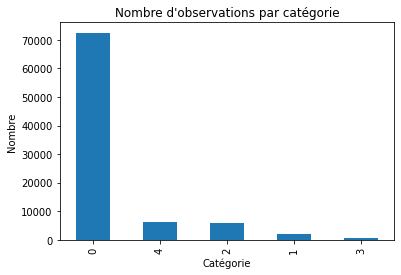

In [0]:
ax = labels.plot(kind='bar',title="Nombre d'observations par catégorie")
ax.set_xlabel("Catégorie")
ax.set_ylabel("Nombre")
plt.show()

In [0]:
def plot_into_category(categorie,n):
  temp = mitbih_train[mitbih_train[187] == categorie].sample(n = n, random_state = 27)
  for i in range(n):
    plt.plot(temp.iloc[i,:186], color="red", alpha=.5)
    plt.title('Représentation enregistrements de la catégorie '+str(Classes[categorie]))
  plt.show()

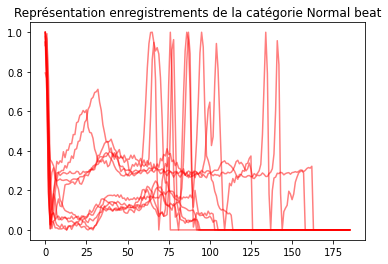

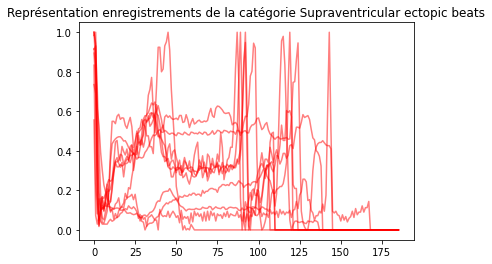

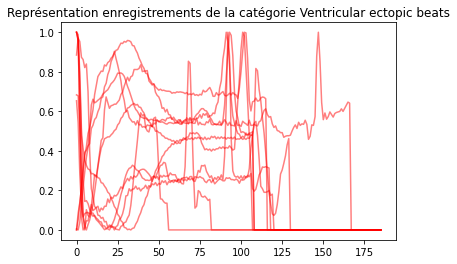

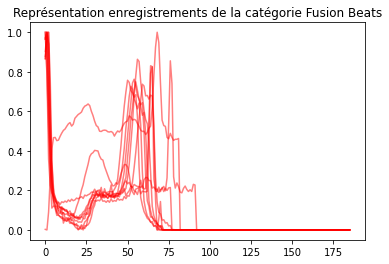

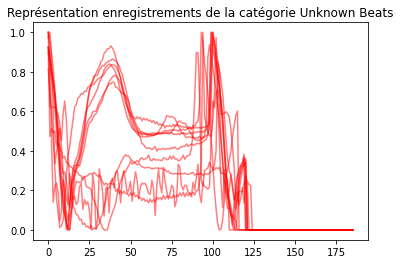

In [0]:
for i in range(5):
  plot_into_category(i,10)

### Si on fait un histogramme de l'ensemble des signaux selon a classe considérée

In [0]:
def plot_hist(class_number,size,min_):
    img = mitbih_train.loc[mitbih_train[187] == class_number].values
    img = img[:,min_:size]
    img_flatten = img.flatten()
    final1 = np.arange(min_,size)
    for i in range(img.shape[0]-1):
      tempo1 = np.arange(min_,size)
      final1 = np.concatenate((final1, tempo1), axis=None)
    plt.hist2d(final1, img_flatten, bins=(80,80), cmap=plt.cm.jet)
    plt.show()

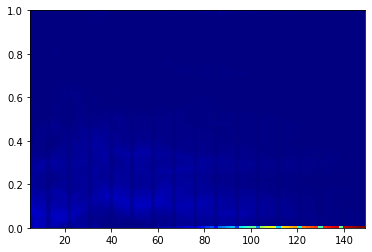

In [0]:
plot_hist(0,150,5)

In [0]:
plot_hist(0,70,5)

In [0]:
from sklearn.utils import resample

In [0]:
def build_train_set(upsample):
  if upsample == "yes":
    df_1 = mitbih_train[mitbih_train[187]==1]
    df_2 = mitbih_train[mitbih_train[187]==2]
    df_3 = mitbih_train[mitbih_train[187]==3]
    df_4 = mitbih_train[mitbih_train[187]==4]
    df_0 = (mitbih_train[mitbih_train[187]==0]).sample(n=20000,random_state=27)

    df_1_upsample = resample(df_1,replace=True,n_samples=20000,random_state=123)
    df_2_upsample = resample(df_2,replace=True,n_samples=20000,random_state=124)
    df_3_upsample = resample(df_3,replace=True,n_samples=20000,random_state=125)
    df_4_upsample = resample(df_4,replace=True,n_samples=20000,random_state=126)

    train_df = pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
  else:
    train_df = mitbih_train
  return train_df

In [0]:
train_df = build_train_set("non")

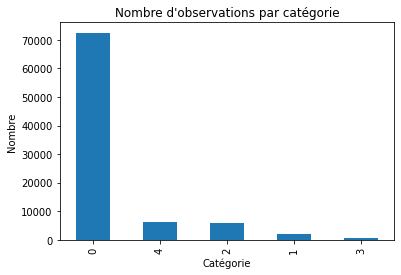

In [0]:
labels_train = train_df[187].astype(int).value_counts()
ax = labels_train.plot(kind='bar',title="Nombre d'observations par catégorie")
ax.set_xlabel("Catégorie")
ax.set_ylabel("Nombre")
plt.show()

### Preprocessing

In [0]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [0]:
Y_train = np.array(train_df[187].values).astype(np.int8)
X_train = np.array(train_df[list(range(187))].values)
Y_test = np.array(mitbih_test[187].values).astype(np.int8)
X_test = np.array(mitbih_test[list(range(187))].values)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_sparse = csr_matrix(X_train_scaled)

### Benchmark 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [0]:
def show_eval(y_true, y_pred, a):
  classifiers_list = ['régression logisitique','réseau de neurones','arbre de decision','SVM']

  print("Rapport de classification pour "+ str(classifiers_list[a]))

  print(classification_report(y_true, y_pred))

  cm = confusion_matrix(y_true, y_pred) 
  labels = ['Normal beat', 'Supraventricular ectopic beats', 'Ventricular ectopic beats', 'Fusion Beats', 'Unknown Beats']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  sns.set(font_scale=1.2)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

In [0]:
logit  = LogisticRegression(multi_class="ovr", class_weight="balanced",n_jobs=2, max_iter=150, C=.5)
svm = SVC(kernel='rbf', decision_function_shape='ovr', random_state=0)
nn = MLPClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
classifiers_list = ['régression logisitique','réseau de neurones','arbre de decision','SVM']

training time : 32.028045415878296
Rapport de classification pour régression logisitique
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     18118
           1       0.33      0.56      0.42       556
           2       0.31      0.65      0.42      1448
           3       0.12      0.80      0.21       162
           4       0.73      0.91      0.81      1608

    accuracy                           0.79     21892
   macro avg       0.49      0.74      0.55     21892
weighted avg       0.89      0.79      0.82     21892



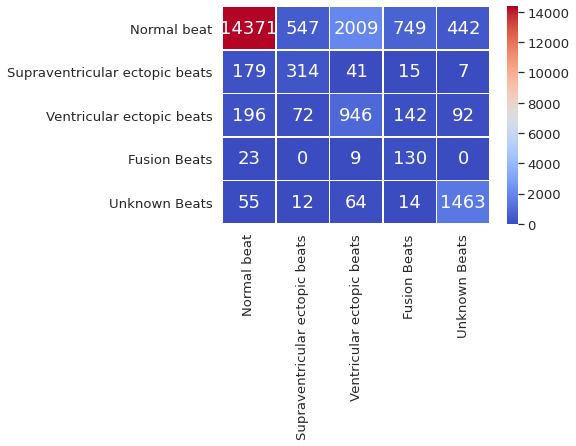

training time : 849.7975594997406
Rapport de classification pour réseau de neurones
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.77      0.74      0.76       556
           2       0.94      0.93      0.93      1448
           3       0.78      0.75      0.77       162
           4       0.98      0.97      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.89      0.88      0.88     21892
weighted avg       0.98      0.98      0.98     21892



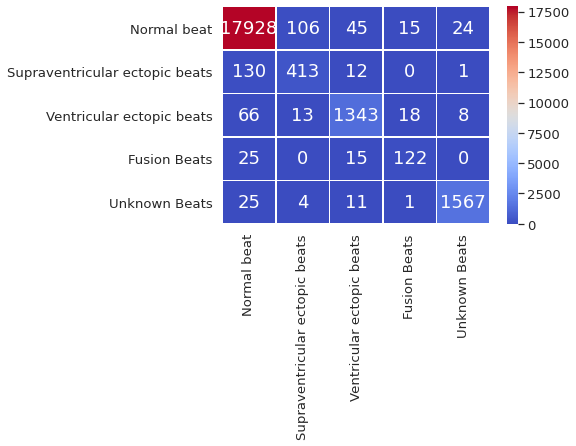

training time : 413.1686677932739
Rapport de classification pour arbre de decision
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18118
           1       0.99      0.59      0.74       556
           2       0.98      0.88      0.93      1448
           3       0.88      0.60      0.72       162
           4       0.99      0.94      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.96      0.80      0.87     21892
weighted avg       0.97      0.97      0.97     21892



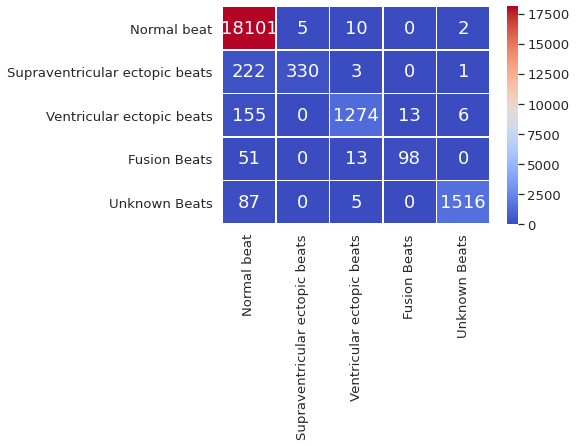

In [0]:
for i,clf in enumerate([logit,nn,rf,svm]):
  start_time = time.time()
  clf.fit(X_train_sparse,Y_train)
  print("training time : "+str(time.time()-start_time))
  y_predict = clf.predict(X_test_scaled)
  show_eval(Y_test, y_predict, i)

#Deep Learning

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import keras
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.python.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, MaxPool1D
from tensorflow.python.keras import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.python.keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from tensorflow.python.keras.optimizers import Adam
from keras import regularizers
from keras.utils.np_utils import to_categorical
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### CNN

In [0]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
Y_train_k = keras.utils.to_categorical(Y_train, 5)
Y_test_k = keras.utils.to_categorical(Y_test, 5)

In [0]:
model_CNN = Sequential()
im_shape=(X_train.shape[1],1)
model_CNN.add(Conv1D(64, (3), input_shape=im_shape, activation='relu'))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='softmax'))
model_CNN.add(Dense(5, activation='softmax'))
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 185, 64)           256       
_________________________________________________________________
flatten (Flatten)            (None, 11840)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                757824    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 758,405
Trainable params: 758,405
Non-trainable params: 0
_________________________________________________________________


In [0]:
histo = model_CNN.fit(X_train, Y_train_k,epochs=10, batch_size=128,validation_data=(X_test, Y_test_k))
y_pred = model_CNN.predict(X_test)
print(classification_report(Y_test_k.argmax(axis=1), y_pred.argmax(axis=1)))

Epoch 1/10
685/685 [==============================] - 2s 3ms/step - loss: 0.8524 - accuracy: 0.8258 - val_loss: 0.6076 - val_accuracy: 0.8276
Epoch 2/10
685/685 [==============================] - 2s 3ms/step - loss: 0.5232 - accuracy: 0.8749 - val_loss: 0.4905 - val_accuracy: 0.8821
Epoch 3/10
685/685 [==============================] - 2s 3ms/step - loss: 0.4502 - accuracy: 0.8812 - val_loss: 0.4079 - val_accuracy: 0.8859
Epoch 4/10
685/685 [==============================] - 2s 3ms/step - loss: 0.3697 - accuracy: 0.9062 - val_loss: 0.3496 - val_accuracy: 0.9131
Epoch 5/10
685/685 [==============================] - 2s 3ms/step - loss: 0.3222 - accuracy: 0.9169 - val_loss: 0.3001 - val_accuracy: 0.9211
Epoch 6/10
685/685 [==============================] - 2s 3ms/step - loss: 0.2567 - accuracy: 0.9323 - val_loss: 0.2276 - val_accuracy: 0.9423
Epoch 7/10
685/685 [==============================] - 2s 3ms/step - loss: 0.2089 - accuracy: 0.9449 - val_loss: 0.2128 - val_accuracy: 0.9425
Epoch 

In [0]:
n_most_common_words = 8000
emb_dim = 128
model_LSTM = Sequential()
model_LSTM.add(Embedding(n_most_common_words, emb_dim, input_length = X_train.shape[1]))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(LSTM(100))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 160, 128)          1024000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 160, 128)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               91600     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 505       
Total params: 1,116,105
Trainable params: 1,116,105
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
Y_train = np.array(train_df[187].values).astype(np.int8)
X_train = np.array(train_df[list(range(187))].values)
X_train = pad_sequences(X_train, maxlen=160)
Y_test = np.array(mitbih_test[187].values).astype(np.int8)
X_test = np.array(mitbih_test[list(range(187))].values)
X_test = pad_sequences(X_test, maxlen=160)
Y_train_k = keras.utils.to_categorical(Y_train, 5)
Y_test_k = keras.utils.to_categorical(Y_test, 5)

In [0]:
print(X_train.shape,Y_train_k.shape,X_test.shape,Y_test_k.shape)

(87554, 160) (87554, 5) (21892, 160) (21892, 5)


In [0]:
histo= model_LSTM.fit(X_train, Y_train_k, epochs = 10, batch_size = 128,  validation_data=(X_test,Y_test_k))
y_pred = model_LSTM.predict(X_test, batch_size=1000)
print(classification_report(Y_test_k.argmax(axis=1), y_pred.argmax(axis=1)))

Epoch 1/10
685/685 [==============================] - 17s 25ms/step - loss: 0.6758 - accuracy: 0.8267 - val_loss: 0.6697 - val_accuracy: 0.8276
Epoch 2/10
685/685 [==============================] - 17s 25ms/step - loss: 0.6627 - accuracy: 0.8277 - val_loss: 0.6687 - val_accuracy: 0.8276
Epoch 3/10
685/685 [==============================] - 17s 25ms/step - loss: 0.6626 - accuracy: 0.8277 - val_loss: 0.6668 - val_accuracy: 0.8273
Epoch 4/10
685/685 [==============================] - 17s 25ms/step - loss: 0.6580 - accuracy: 0.8279 - val_loss: 0.6644 - val_accuracy: 0.8284
Epoch 5/10
685/685 [==============================] - 17s 25ms/step - loss: 0.6553 - accuracy: 0.8284 - val_loss: 0.6613 - val_accuracy: 0.8283
Epoch 6/10
685/685 [==============================] - 17s 25ms/step - loss: 0.6173 - accuracy: 0.8280 - val_loss: 0.5853 - val_accuracy: 0.8283
Epoch 7/10
685/685 [==============================] - 17s 25ms/step - loss: 0.5881 - accuracy: 0.8276 - val_loss: 0.5829 - val_accuracy:

### Deep Learning complexe

In [0]:
model_2 = Sequential()
im_shape=(X_train.shape[1],1)
model_2.add(Conv1D(64, (6), input_shape=im_shape, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))
model_2.add(Convolution1D(64, (3), activation='relu', input_shape=im_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))
model_2.add(Convolution1D(64, (3), activation='relu', input_shape=im_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(5, activation='softmax'))
model_2.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 182, 64)           448       
_________________________________________________________________
batch_normalization_34 (Batc (None, 182, 64)           256       
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 91, 64)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 89, 64)            12352     
_________________________________________________________________
batch_normalization_35 (Batc (None, 89, 64)            256       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 45, 64)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 43, 64)          

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
histo = model_2.fit(X_train, Y_train_k,epochs=40,callbacks=callbacks, batch_size=128,validation_data=(X_test, Y_test_k))
model_2.load_weights('best_model.h5')

Train on 87554 samples, validate on 21892 samples
Epoch 1/40
87554/87554 [==============================] - 11s 125us/step - loss: 0.1376 - acc: 0.9613 - val_loss: 0.0994 - val_acc: 0.9732
Epoch 2/40
87554/87554 [==============================] - 9s 106us/step - loss: 0.0720 - acc: 0.9796 - val_loss: 0.0963 - val_acc: 0.9731
Epoch 3/40
87554/87554 [==============================] - 9s 101us/step - loss: 0.0590 - acc: 0.9826 - val_loss: 0.0809 - val_acc: 0.9777
Epoch 4/40
87554/87554 [==============================] - 9s 104us/step - loss: 0.0486 - acc: 0.9852 - val_loss: 0.0966 - val_acc: 0.9757
Epoch 5/40
87554/87554 [==============================] - 9s 104us/step - loss: 0.0414 - acc: 0.9873 - val_loss: 0.0683 - val_acc: 0.9820
Epoch 6/40
87554/87554 [==============================] - 9s 104us/step - loss: 0.0363 - acc: 0.9885 - val_loss: 0.0702 - val_acc: 0.9814
Epoch 7/40
87554/87554 [==============================] - 9s 105us/step - loss: 0.0326 - acc: 0.9895 - val_loss: 0.0674 -

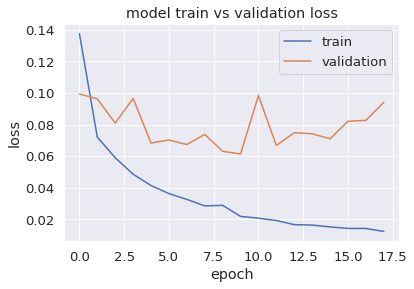

In [0]:
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
y_pred = model_2.predict(X_test)

In [0]:
scores = model_2.evaluate((X_test),Y_test_k, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.50%


In [0]:
print(classification_report(Y_test_k.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.87      0.81      0.84       556
           2       0.97      0.95      0.96      1448
           3       0.88      0.76      0.81       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.94      0.90      0.92     21892
weighted avg       0.98      0.98      0.98     21892



In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
recall_score(Y_test_k.argmax(axis=1), y_pred.argmax(axis=1), average="macro")

0.9007741530568432

In [0]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


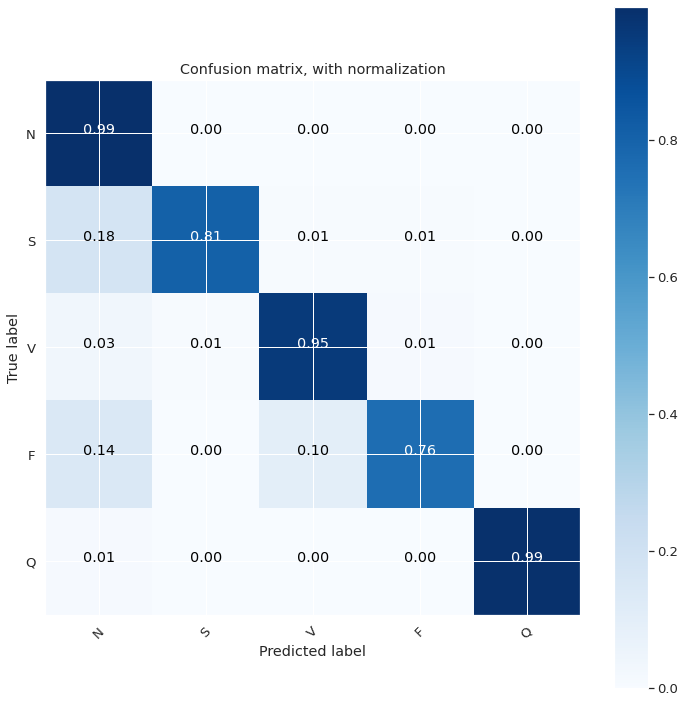

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True, title='Confusion matrix, with normalization')
plt.show()

### Resnet

NN  de ce papier : https://arxiv.org/pdf/1805.00794.pdf

In [0]:
import tensorflow.keras.optimizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [0]:
model = Sequential()
im_shape=(X_train.shape[1],1)

model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(MaxPool1D(pool_size=(5), strides=(2)))

model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(MaxPool1D(pool_size=(5), strides=(2)))

model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(MaxPool1D(pool_size=(5), strides=(2)))

model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(MaxPool1D(pool_size=(5), strides=(2)))

model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(Conv1D(32, (5), input_shape=im_shape, strides=1, padding= 'same', activation ="relu"))
model.add(MaxPool1D(pool_size=(5), strides=(2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer= tensorflow.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 160, 32)           192       
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 160, 32)           5152      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 78, 32)            0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 78, 32)            5152      
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 78, 32)            5152      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 37, 32)          

In [0]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [0]:
history = model.fit(X_train, Y_train_k, epochs=75, batch_size=500, verbose=2,  validation_data=(X_test, Y_test_k), callbacks=[lrate])

AttributeError: ignored

In [0]:
y_pred = model.predict(X_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

NameError: ignored